In [1]:
# from __future__ import print_function, division
from keras.utils import plot_model
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate, Lambda, Reshape
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose, MaxPooling2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
import sys,os

import numpy as np
import cv2
import random
from PIL import Image
from theano import tensor as T

Using TensorFlow backend.


In [75]:
def log_sum_exp(x, axis=None, keepdims=False):
    '''Numerically stable log( sum( exp(A) ) ).
    '''
    x_max = K.max(x, axis=axis, keepdims=True)
    y = K.log(K.sum(K.exp(x - x_max), axis=axis, keepdims=True)) + x_max
    y = K.sum(y, axis=axis, keepdims=keepdims)
    return y

In [ ]:
class BGAN():
    """Reference: https://wiseodd.github.io/techblog/2017/03/07/boundary-seeking-gan/"""
    def __init__(self):
        pass
    
    def build(self, imgshape, latentnum, path, optimizer="Adam", nettype="FC",g_lr=0.0002, d_lr=0.0002):
#         self.img_rows = 28
#         self.img_cols = 28
#         self.channels = 1
        self.img_shape = imgshape
        self.latent_dim = latentnum
        self.path=path
        self.history=[]
        if optimizer=="Adam":
            g_opt=Adam(g_lr, 0.5)
            d_opt=Adam(d_lr, 0.5)

        # Build and compile the discriminator
        if nntype=="FC":
            self.discriminator = self.build_discriminator()
        elif nntype=="CNN":
            self.discriminator = self.build_discriminator_CNN()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=d_opt,
            metrics=['accuracy'])
        self.discriminator.summary()
        
        # Build the generator
        if nntype=="FC":
            self.generator = self.build_generator()
        elif nntype=="CNN":
            self.generator = self.build_generator_CNN()
        self.generator.summary()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator(tensor)
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.boundary_loss, optimizer=g_opt)
        self.combined.summary()
    
    def build_generator(self):

        model = Sequential()
    
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

#         model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
#         model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def build_generator_CNN(self):
        
        noise = Input(shape=(self.latent_dim,))
        model=Dense(7*7*16, input_dim=self.latent_dim)(noise)
        model=BatchNormalization()(model)
        model=LeakyReLU(alpha=0.1)(model)
#         model=Dense(512, activation="relu")(model)
#         model=LeakyReLU(alpha=0.2)(model)
#         model=BatchNormalization()(model)
        model=Reshape(target_shape=(7,7,16))(model)
    
        model=Conv2DTranspose(8, kernel_size=5, strides=2, padding="same")(model)
        model=BatchNormalization()(model)
        model=LeakyReLU(alpha=0.1)(model)
#         model=Conv2DTranspose(4, kernel_size=5, strides=2, padding="same")(model)
#         model=BatchNormalization()(model)
#         model=LeakyReLU(alpha=0.2)(model)
        model=Conv2DTranspose(self.img_shape[2], kernel_size=5, strides=2, padding="same", activation="tanh")(model)
        
        
#         # Use Upsampling2D
#         noise = Input(shape=(self.latent_dim,))
#         model=Dense(3*3*128, input_dim=self.latent_dim)(noise)
#         model=BatchNormalization()(model)
#         model=LeakyReLU(alpha=0.2)(model)
#         model=Reshape(target_shape=(3,3,128))(model)
#         model=Conv2D(64, kernel_size=3, strides=1, padding="same", activation="relu")(model)
#         model=UpSampling2D((2, 2))(model)
# #         model=BatchNormalization()(model)
# #         model=LeakyReLU(alpha=0.2)(model)
#         model=Conv2D(32, kernel_size=3, strides=1, padding="same", activation="relu")(model)
#         model=UpSampling2D((2, 2))(model)
# #         model=BatchNormalization()(model)
# #         model=LeakyReLU(alpha=0.2)(model)
#         model=Conv2D(self.img_shape[2], kernel_size=3, strides=1, padding="same")(model)
#         model=UpSampling2D((2, 2))(model)
#         model=Activation("tanh")(model)
        
        return Model(noise, model)
    
    def build_discriminator_CNN(self):
        
#         self.img_shape=(28,28,1)
        im = Input(shape=self.img_shape)
        model=Conv2D(16, kernel_size=5, strides=2, padding="same")(im)
#         model=BatchNormalization()(model)
        model=LeakyReLU(alpha=0.1)(model)
        model=Conv2D(32, kernel_size=5, strides=2, padding="same")(model)
        model=BatchNormalization()(model)
        model=LeakyReLU(alpha=0.1)(model)
#         model=Conv2D(32, kernel_size=5, strides=2, padding="same")(model)
#         model=BatchNormalization()(model)
#         model=LeakyReLU(alpha=0.2)(model)
        model=Flatten()(model)
        model=Dense(1, activation="sigmoid")(model)
        return Model(im, model)
    
    def boundary_loss(self, y_true, y_pred):
        """
        Boundary seeking loss.
        Reference: https://wiseodd.github.io/techblog/2017/03/07/boundary-seeking-gan/
        """
        return 0.5 * K.mean((K.log(y_pred) - K.log(1 - y_pred))**2)

    def train(self, X_train, epochs, batch_size=128, sample_interval=50):

#         # Load the dataset
#         (X_train, _), (_, _) = mnist.load_data()
        self.history=np.zeros((epochs, 4))
        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        dg=datagen_norepeat(batch_size, X_train)# randomly generate data without repeating
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
#             idx = np.random.randint(0, X_train.shape[0], batch_size)
            idx=next(dg)# yield next batch
            imgs = X_train[idx]
            

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # half positive, half negtive
            
#             d_loss=self.discriminator.train_on_batch(np.vstack((imgs,gen_imgs)), np.vstack((valid,fake)))

#             comb_x=np.vstack((imgs,gen_imgs))
#             comb_y=np.vstack((valid,fake))
#             idx_sh=np.random.shuffle(np.arange(batch_size*2))
#             d_loss_real = self.discriminator.train_on_batch(comb_x[0:batch_size], comb_y[0:batch_size])
#             d_loss_fake = self.discriminator.train_on_batch(comb_x[batch_size:], comb_y[batch_size:])
#             d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch+1, d_loss[0], 100*d_loss[1], g_loss))
            self.history[epoch,:]=[epoch+1, d_loss[0], 100*d_loss[1], g_loss]
            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(self.path+"/mnist_%d.png" % epoch)
        plt.close()

# Save model

In [364]:
bgan.discriminator.save_weights(os.getcwd()+"/model/bgan_disc_weights_%s_%s.h5" % (datatype, nntype))
bgan.generator.save_weights(os.getcwd()+"/model/bgan_gene_weights_%s_%s.h5" % (datatype, nntype))
np.save(os.getcwd()+"/model/hist_%s_batchsize%d_glr%f_dlr%f_%s.npy" % (datatype, batchsize, glrate, dlrate, nntype),
        bgan.history)

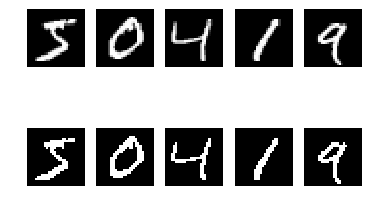

In [21]:
def testplot(img_cont, img_disc):
    img_disc=img_disc.reshape(-1,28,28)
    r, c = 2, 5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for j in range(c):
        
#     for i in range(r):
        axs[0,j].imshow(img_cont[cnt, :,:], cmap='gray')
        axs[0,j].axis('off')
        axs[1,j].imshow(img_disc[cnt, :,:], cmap='gray')
        axs[1,j].axis('off')
        cnt += 1
#         fig.savefig(self.path+"/mnist_%d.png" % epoch)
    plt.show()
    return

testplot(X_train_cont, X_train_disc)